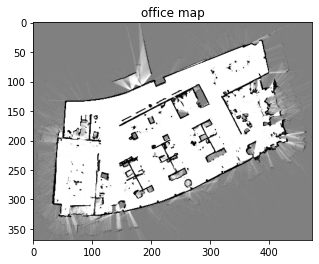

In [1]:
import cv2
from matplotlib import pyplot as plt

img = cv2.imread('osrc_paper_windows.png')
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
plt.imshow(img)
plt.title('office map')
plt.show()

In [2]:
img.shape

(369, 473, 3)

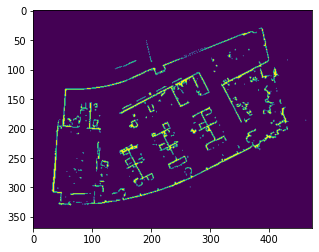

In [3]:
import numpy as np
res = cv2.inRange(img,np.array([0,0,0]),np.array([30,30,30]))
#res = res*100.0

kernel = np.ones((5,5),np.uint8)
#res = cv2.dilate(res, kernel)
#res = cv2.erode(res, kernel)
#res = cv2.dilate(res, kernel)
plt.imshow(res)
plt.show()

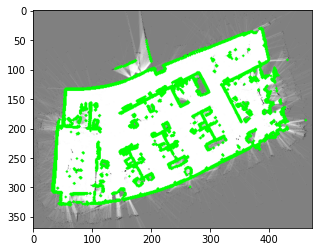

In [4]:
contours, hierarchy = cv2.findContours(res*100, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
img_con = img.copy()
cv2.drawContours(img_con, contours, -1, (0,255,0), 3)
plt.imshow(img_con)
plt.show()

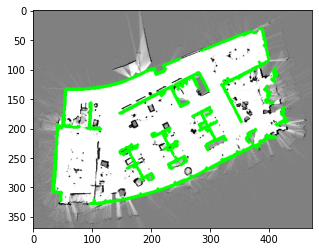

In [56]:
filtered_cont = []
for contour in contours:
    if cv2.arcLength(contour, False) < 70:
        continue
    filtered_cont.append(contour)
img_con = img.copy()
cv2.drawContours(img_con, filtered_cont, -1, (0,255,0), 3)
plt.imshow(img_con)
plt.show()

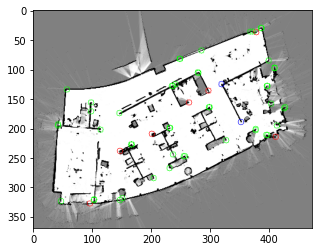

In [57]:
img_keypoints = img.copy()
lidar_end_points = []
for contour in filtered_cont:
    prev_pt = None
    prev_prev_pt = None
    counter = 0
    simplified_cont =  cv2.approxPolyDP(contour, 30, True)
    for pt in simplified_cont:
        if prev_pt is None:
            cv2.circle(img_keypoints, (pt[0][0], pt[0][1]), 5, (255,0,0), 1)
            lidar_end_points.append([pt[0][0], pt[0][1]])
        elif counter == len(simplified_cont) - 1:
            cv2.circle(img_keypoints, (pt[0][0], pt[0][1]), 5, (0,255,0), 1)
            lidar_end_points.append([pt[0][0], pt[0][1]])
        elif prev_prev_pt is not None:      
            vec1 = prev_pt - prev_prev_pt
            vec2 = pt[0] - prev_pt
            angle = np.arccos(vec1.dot(vec2)/(np.linalg.norm(vec1) * np.linalg.norm(vec2)))
            if abs(angle) > 1.4:
                cv2.circle(img_keypoints, (prev_pt[0], prev_pt[1]), 5, (0, 0, 255), 1)
                lidar_end_points.append([prev_pt[0], prev_pt[1]])
            #if abs(angle) < 0.1 and vec1.dot(vec2) <0:
            #    cv2.circle(img_keypoints, (prev_pt[0], prev_pt[1]), 5, (0, 0, 255), 1)
            #    lidar_end_points.append([prev_pt[0], prev_pt[1]])
        prev_prev_pt = prev_pt
        prev_pt = pt[0]
        counter += 1
    cv2.circle(img_keypoints, (contour[-1][0][0], contour[-1][0][1]), 5, (0,255,0), 1)
    lidar_end_points.append((contour[-1][0][0], contour[-1][0][1]))
    cv2.circle(img_keypoints, (contour[0][0][0], contour[0][0][1]), 5, (0,255,0), 1)
    lidar_end_points.append((contour[0][0][0], contour[0][0][1]))
    
lidar_end_points = np.array(lidar_end_points)
plt.imshow(img_keypoints)
plt.show()

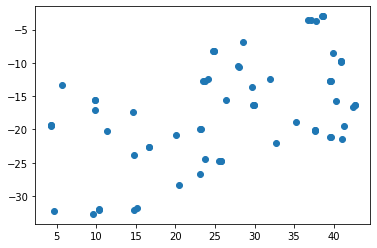

In [58]:
plt.scatter(lidar_end_points[:,0]/10, -lidar_end_points[:,1]/10)
plt.show()

In [60]:
import yaml

file = open("office.building.yaml")
office_map = yaml.load(file)

vertices = office_map["levels"]["L1"]["vertices"]

verts = np.array([[vertex[0], vertex[1]] for vertex in vertices])

walls = office_map["levels"]["L1"]["walls"]

measurements = office_map["levels"]["L1"]["measurements"]

wall_vertex_indices = set([wall[0] for wall in walls] + [wall[1] for wall in walls])

wall_verts = verts[list(wall_vertex_indices)]

<ipython-input-60-087b58f30282>:4: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  office_map = yaml.load(file)


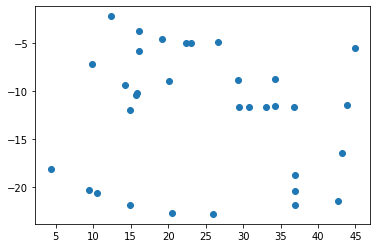

In [61]:
dx = np.array(wall_verts[measurements[0][0]]) - np.array(wall_verts[measurements[0][1]])
norm = measurements[0][2]["distance"][-1]
pixel_norm = np.linalg.norm(dx)
scale = norm/pixel_norm
verts_transformed = np.array([[v[0]*scale, -v[1]*scale] for v in wall_verts])
plt.scatter(verts_transformed[:,0], verts_transformed[:,1])
plt.show()

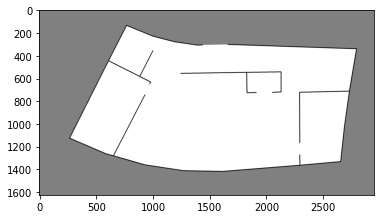

In [72]:
def to_gridmap(yaml_map):
    vertices = yaml_map["vertices"]
    verts = np.array([[int(vertex[0]), int(vertex[1])] for vertex in vertices])
    width, height = (int(max(verts[:,0])), int(max(verts[:,1])))
    img = np.ones((height,width,3), np.uint8)*128
    floor_perimeter = []
    for edge in yaml_map["floors"][0]["vertices"]:
        pt = tuple(verts[edge])
        floor_perimeter.append(pt)
    floor_perimeter = np.array([[floor_perimeter]], dtype="int32")
    cv2.fillPoly(img, floor_perimeter, (255,255,255))
    for wall in yaml_map["walls"]:
        start = tuple(verts[wall[0]])
        end = tuple(verts[wall[1]])
        cv2.line(img, start, end, (0,0,0), 5)
    return img

img = to_gridmap(office_map["levels"]["L1"])
plt.imshow(img)
plt.show()